<a href="https://colab.research.google.com/github/manjum2050/my_website/blob/master/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit Card Fraud
In this part of the series, we will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

#Setup
We will be using TensorFlow version: 2.13.0 and keras version: 2.13.1 Let's begin:

In [95]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import keras as kp
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [96]:
print("TensorFlow version:", tf.__version__)
print("keras version:", kp.__version__)

TensorFlow version: 2.13.0
keras version: 2.13.1


#Loading the data
The dataset we're going to use can be downloaded from Kaggle.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [97]:
df = pd.read_csv("creditcard.csv")

#Exploration

Print the data

In [98]:
top_4_rows = df.head(4)
print(top_4_rows)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [99]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [100]:
df.isnull().values.any()

False

#Examining the missing values amd displaying the percentage of null values in each feature column

In [101]:
data = df.copy()
feature_names= list(data)
for i in feature_names:
    null_values = data[i].isnull().sum()
    nrow = data[i].count()
    missing_value_percent = (null_values/nrow)*100
    print(i +" " + ":" + " " + "Null_value_Percentage" + "=" + str(missing_value_percent) + "%","\n")


Time : Null_value_Percentage=0.0% 

V1 : Null_value_Percentage=0.0% 

V2 : Null_value_Percentage=0.0% 

V3 : Null_value_Percentage=0.0% 

V4 : Null_value_Percentage=0.0% 

V5 : Null_value_Percentage=0.0% 

V6 : Null_value_Percentage=0.0% 

V7 : Null_value_Percentage=0.0% 

V8 : Null_value_Percentage=0.0% 

V9 : Null_value_Percentage=0.0% 

V10 : Null_value_Percentage=0.0% 

V11 : Null_value_Percentage=0.0% 

V12 : Null_value_Percentage=0.0% 

V13 : Null_value_Percentage=0.0% 

V14 : Null_value_Percentage=0.0% 

V15 : Null_value_Percentage=0.0% 

V16 : Null_value_Percentage=0.0% 

V17 : Null_value_Percentage=0.0% 

V18 : Null_value_Percentage=0.0% 

V19 : Null_value_Percentage=0.0% 

V20 : Null_value_Percentage=0.0% 

V21 : Null_value_Percentage=0.0% 

V22 : Null_value_Percentage=0.0% 

V23 : Null_value_Percentage=0.0% 

V24 : Null_value_Percentage=0.0% 

V25 : Null_value_Percentage=0.0% 

V26 : Null_value_Percentage=0.0% 

V27 : Null_value_Percentage=0.0% 

V28 : Null_value_Percentage=


#Checking for Null values in the dataset

In [102]:
print(data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Dropping the data point with null values

In [103]:
# Drop rows with null data
df_cleaned = df.dropna()

In [104]:
df_cleaned.isnull().values.any()

False

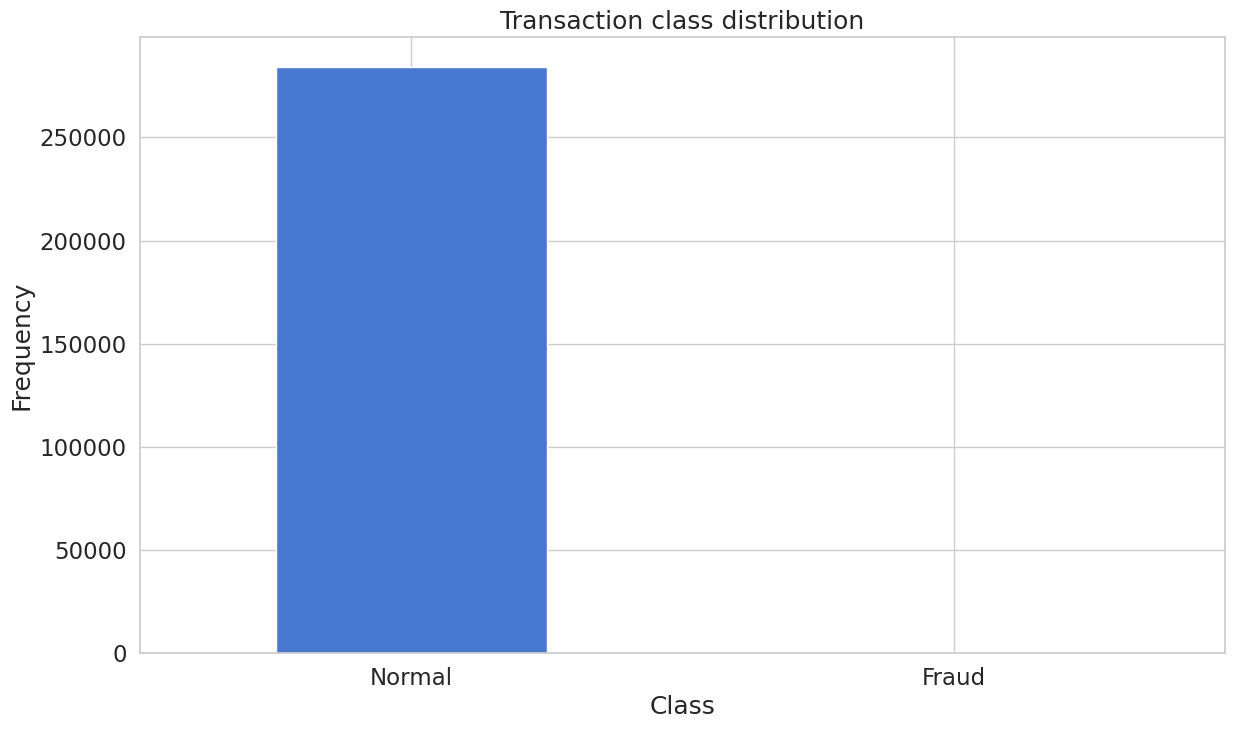

In [105]:
count_classes = pd.value_counts(df_cleaned['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:

In [106]:
frauds = df_cleaned[df_cleaned.Class == 1]
normal = df_cleaned[df_cleaned.Class == 0]


In [107]:
frauds.shape

(492, 31)

In [108]:
normal.shape

(284315, 31)

In [109]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [110]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation:

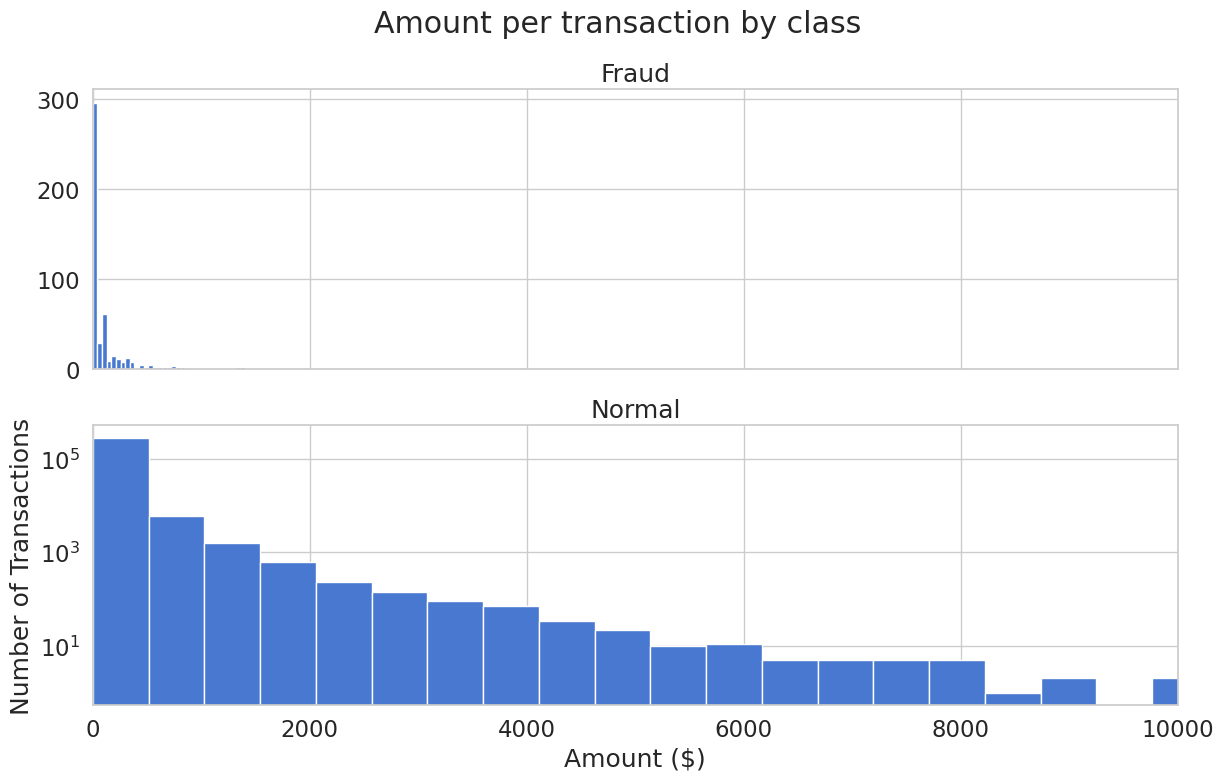

In [111]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 10000))
plt.yscale('log')
plt.show();


Do fraudulent transactions occur more often during certain time?

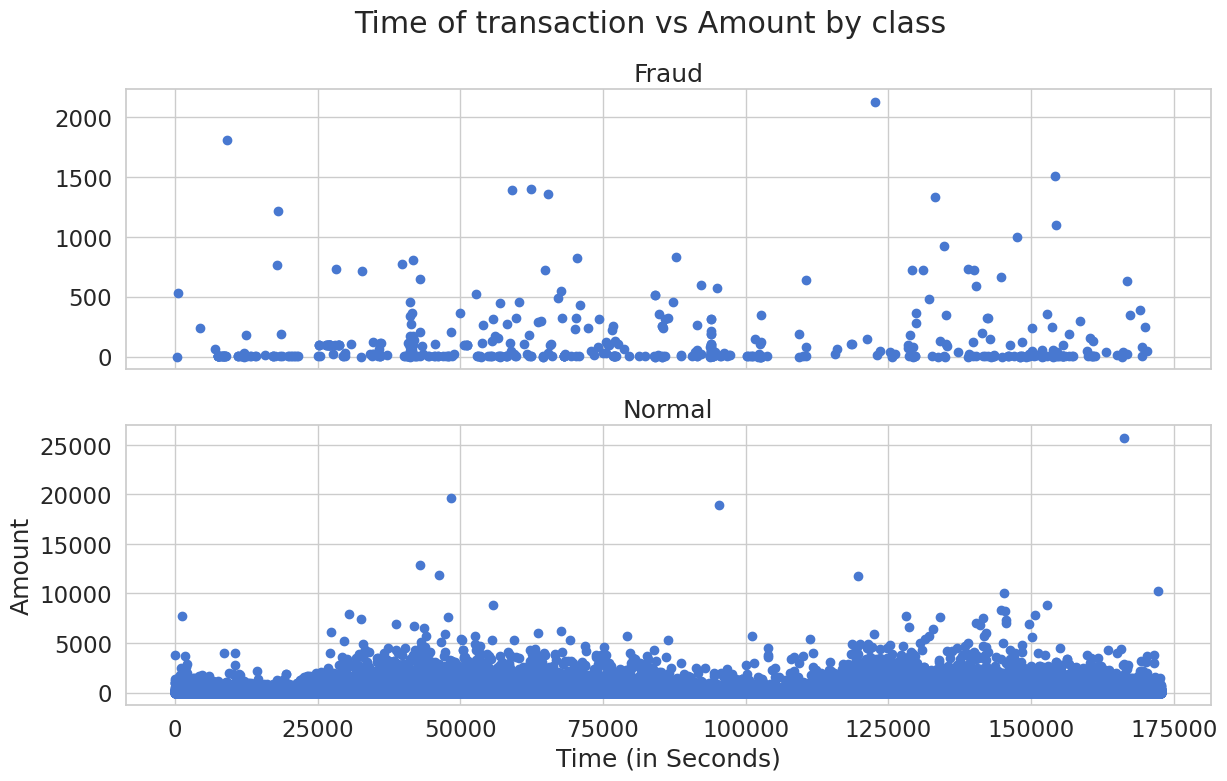

In [112]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matters.

#Autoencoders
Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called undercomplete.

Here's a visual representation of what an Autoencoder might learn:



#Reconstruction error
We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle:

#Preparing the data
First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [113]:
from sklearn.preprocessing import StandardScaler

data = df_cleaned.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [114]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [115]:
print(X)

[[-1.35980713e+00 -7.27811733e-02  2.53634674e+00 ...  1.33558377e-01
  -2.10530535e-02  2.44964263e-01]
 [ 1.19185711e+00  2.66150712e-01  1.66480113e-01 ... -8.98309914e-03
   1.47241692e-02 -3.42474541e-01]
 [-1.35835406e+00 -1.34016307e+00  1.77320934e+00 ... -5.53527940e-02
  -5.97518406e-02  1.16068593e+00]
 ...
 [ 1.91956501e+00 -3.01253846e-01 -3.24963981e+00 ...  4.45477214e-03
  -2.65608286e-02 -8.18393021e-02]
 [-2.40440050e-01  5.30482513e-01  7.02510230e-01 ...  1.08820735e-01
   1.04532821e-01 -3.13248531e-01]
 [-5.33412522e-01 -1.89733337e-01  7.03337367e-01 ... -2.41530880e-03
   1.36489143e-02  5.14355311e-01]]


In [116]:
print(y)

[0 0 0 ... 0 0 0]


#Encoding the Dependent Variable

In [117]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [118]:
print(y)

[0 0 0 ... 0 0 0]


#Splitting the dataset into the Training set and Test set

In [119]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 1)

In [120]:
print(X_train)

[[ 1.38752494 -0.54781112  0.07642226 ... -0.09656016 -0.01484612
  -0.22788939]
 [ 1.02117876 -0.19411366  1.20779128 ...  0.09118751  0.03595947
  -0.18814841]
 [-1.13445277  0.63684293  2.4572414  ...  0.05724697  0.10296089
  -0.26019393]
 ...
 [-1.14996324  1.69646167  1.63711373 ... -0.16204654  0.03119279
  -0.3229239 ]
 [ 1.75455368 -0.69939829 -0.07633214 ... -0.00585291 -0.01962208
   0.02578918]
 [-0.70763501  0.49330227  2.64808871 ... -0.38558861 -0.20558893
  -0.12214001]]


In [121]:
print(len(np.unique(X_train)))

6228529


In [122]:
print(X_test)

[[-0.611712   -0.76970532 -0.14975915 ...  0.06650137  0.22117956
  -0.34607282]
 [-0.81468171  1.31921886  1.32941459 ...  0.16242733  0.05945625
  -0.34531318]
 [-0.31819348  1.1186177   0.96986435 ...  0.2490497   0.09251561
  -0.3496711 ]
 ...
 [-0.72443903 -0.12204732  1.23903035 ...  0.22504217  0.00373454
  -0.17367534]
 [ 1.11927867 -0.17138639  1.08525508 ...  0.05236456  0.02208558
  -0.27578646]
 [-1.23485119 -0.11414336 -0.82577875 ...  0.03426603 -0.04822637
  -0.34999094]]


In [123]:
print(y_train)

[0 0 0 ... 0 0 0]


In [124]:
print(y_test)

[0 0 0 ... 0 0 0]


In [125]:
print(len(np.unique(y_train)))

2


In [126]:
X_train.shape

(227845, 29)

#Building the model
Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [127]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [128]:
print(input_dim)

29


In [129]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [130]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="fraud_detector_model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7121/7121 [==============================] - 21s 3ms/step - loss: 0.8536 - accuracy: 0.5894 - val_loss: 0.7828 - val_accuracy: 0.6283
Epoch 2/100
  71/7121 [..............................] - ETA: 15s - loss: 0.8599 - accuracy: 0.6457

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7121/7121 [==============================] - 22s 3ms/step - loss: 0.7821 - accuracy: 0.6526 - val_loss: 0.7566 - val_accuracy: 0.6542
Epoch 3/100
7121/7121 [==============================] - 19s 3ms/step - loss: 0.7680 - accuracy: 0.6687 - val_loss: 0.7460 - val_accuracy: 0.6719
Epoch 4/100
7121/7121 [==============================] - 21s 3ms/step - loss: 0.7596 - accuracy: 0.6786 - val_loss: 0.7386 - val_accuracy: 0.6828
Epoch 5/100
7121/7121 [==============================] - 19s 3ms/step - loss: 0.7531 - accuracy: 0.6889 - val_loss: 0.7354 - val_accuracy: 0.6875
Epoch 6/100
7121/7121 [==============================] - 20s 3ms/step - loss: 0.7501 - accuracy: 0.6948 - val_loss: 0.7323 - val_accuracy: 0.6916
Epoch 7/100
7121/7121 [==============================] - 19s 3ms/step - loss: 0.7482 - accuracy: 0.6976 - val_loss: 0.7310 - val_accuracy: 0.6927
Epoch 8/100
7121/7121 [==============================] - 20s 3ms/step - loss: 0.7468 - accuracy: 0.7001 - val_loss: 0.7301 - val_accurac

In [131]:
autoencoder = load_model('fraud_detector_model.h5')

#Evaluation

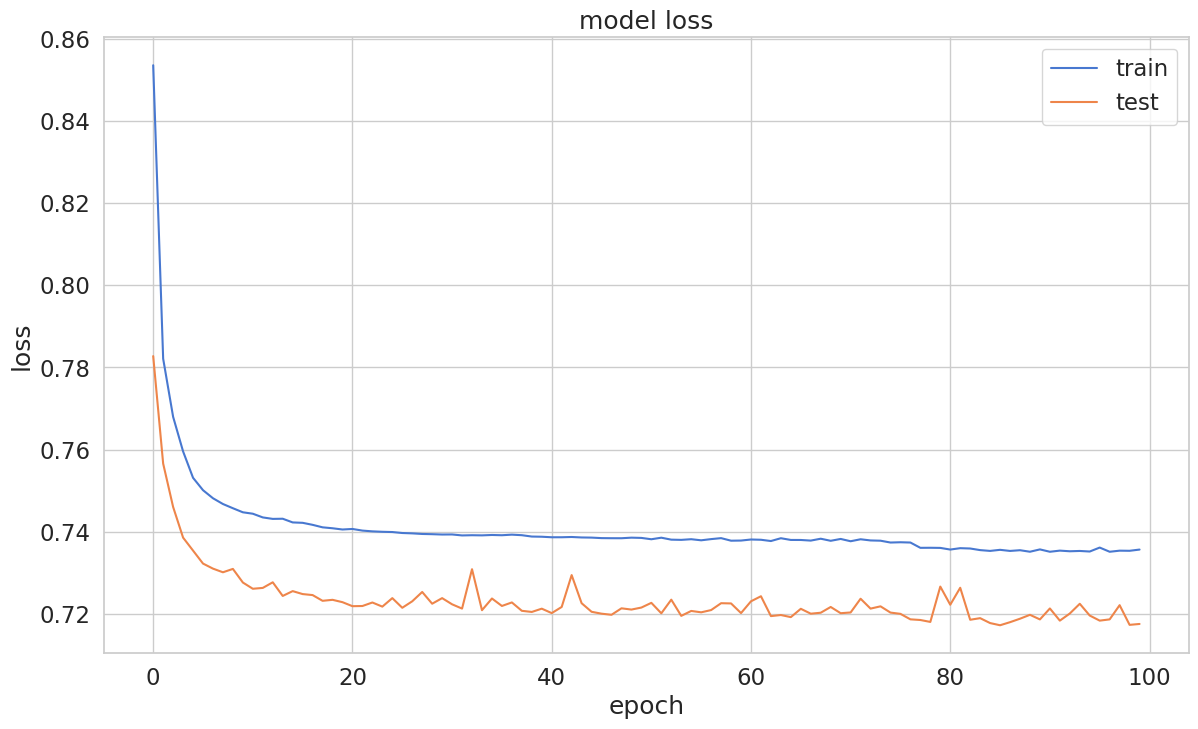

In [132]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');


The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [133]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 3s 1ms/step


In [134]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [135]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.716206,0.001527
std,3.419244,0.039052
min,0.033806,0.000000
25%,0.235911,0.000000
50%,0.379066,0.000000
75%,0.609885,0.000000
max,377.235704,1.000000


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_5, *['reconstruction_error'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_6, *['true_class'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['reconstruction_error'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_8, *['true_class'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_9, *[[['reconstruction_error', 'true_class']]], **{})
chart

#Reconstruction error without fraud

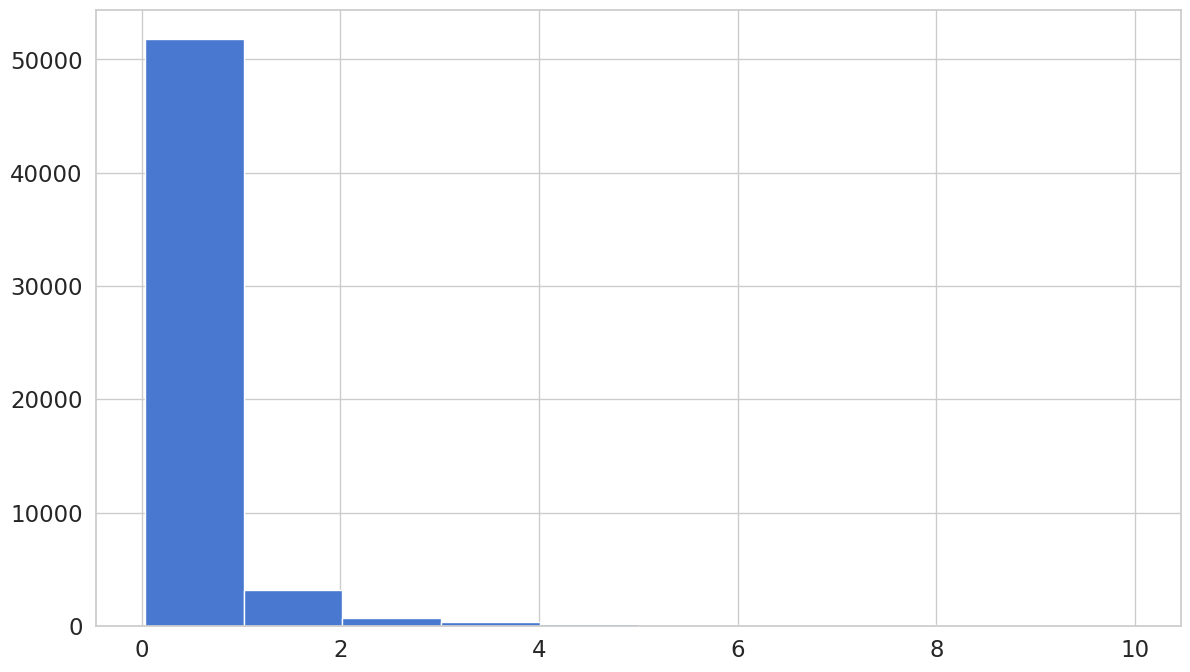

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

#Reconstruction error with fraud

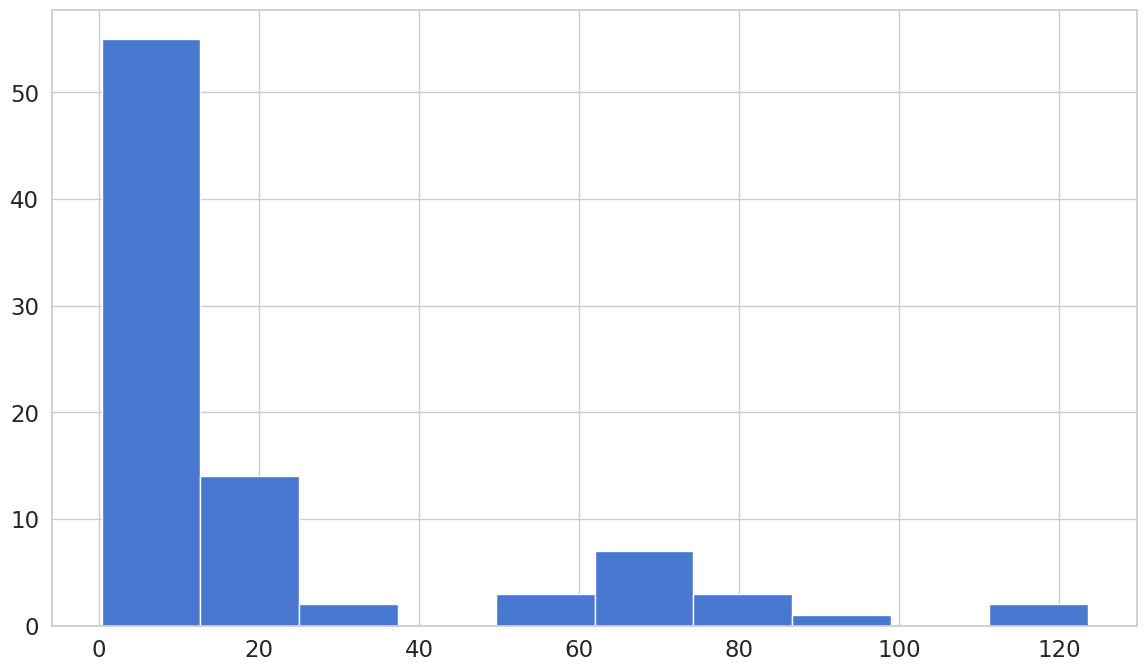

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [149]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, accuracy_score, precision_score, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, classification_report)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

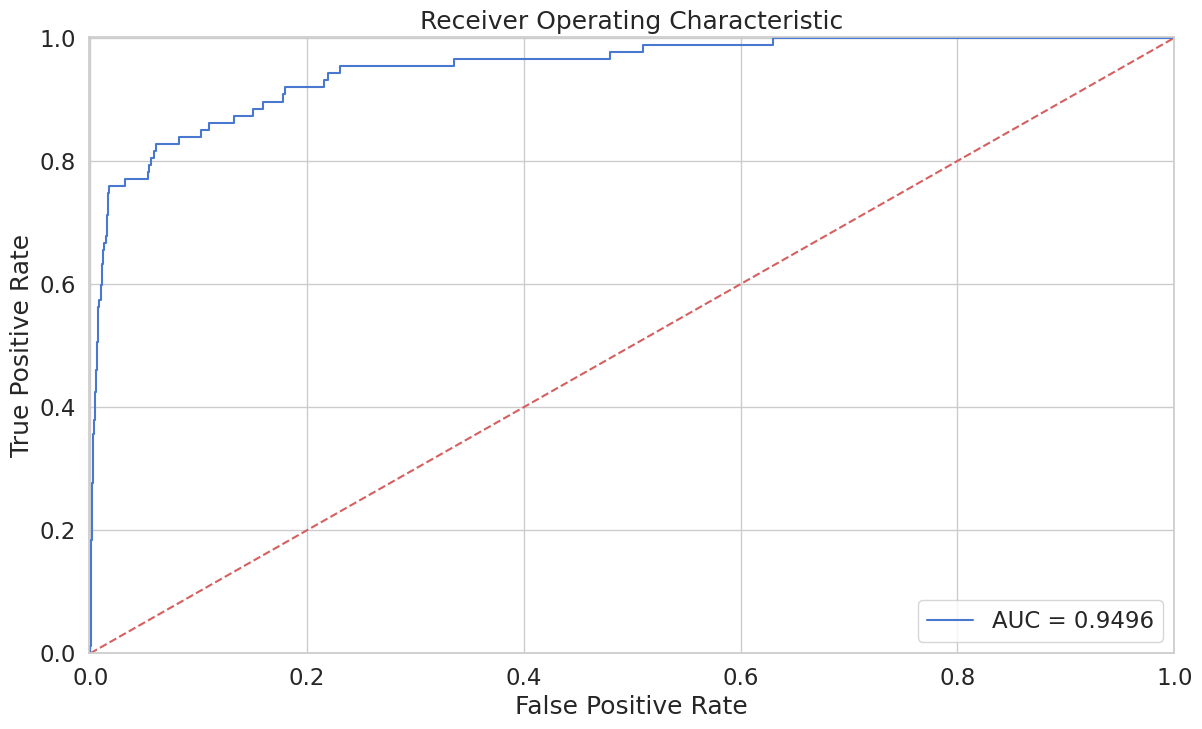

In [150]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC looks very useful for us.

Precision vs Recall

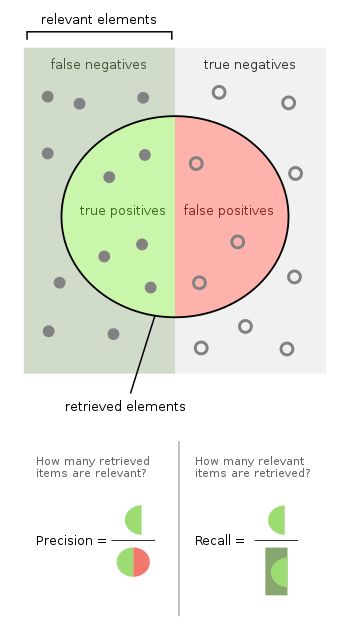

Precision and recall are defined as follows:



Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

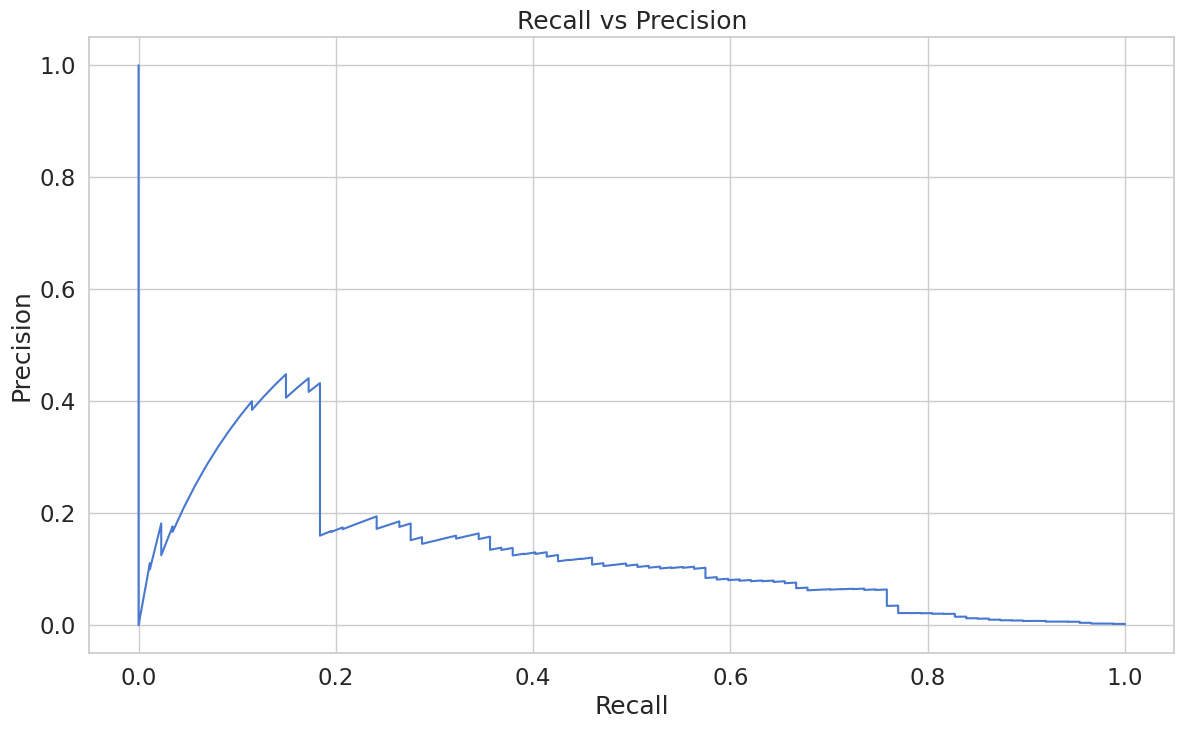

In [151]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

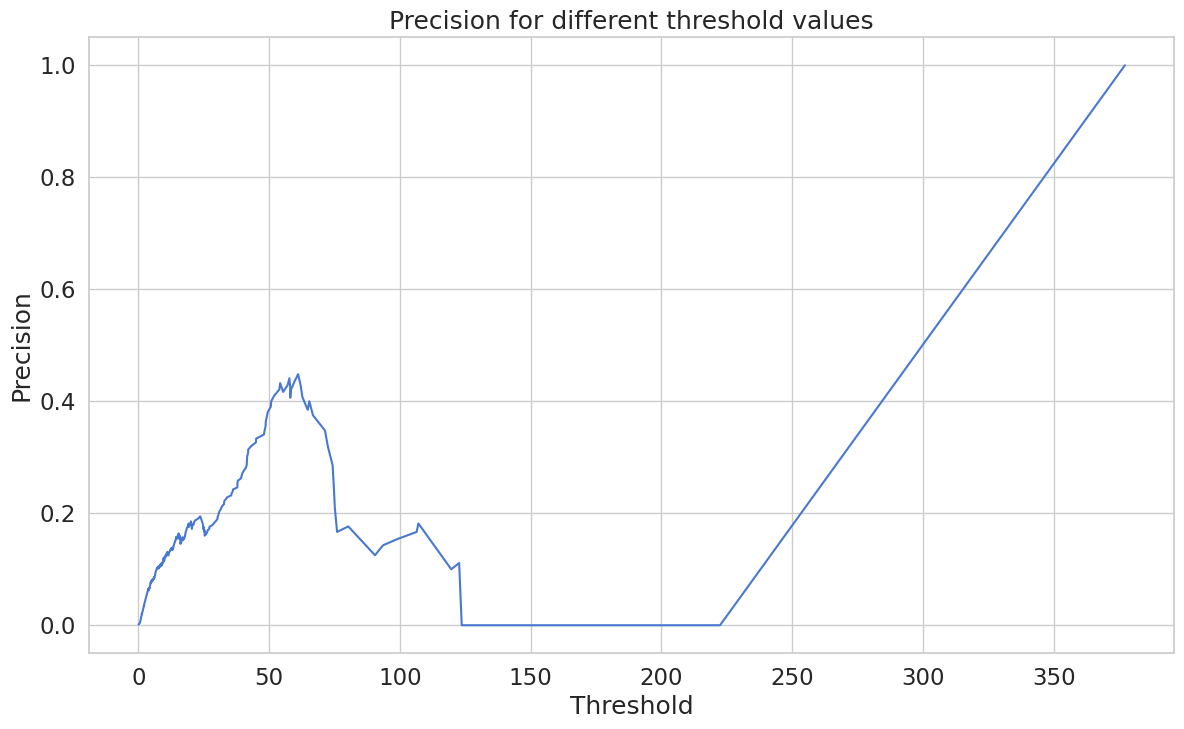

In [152]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

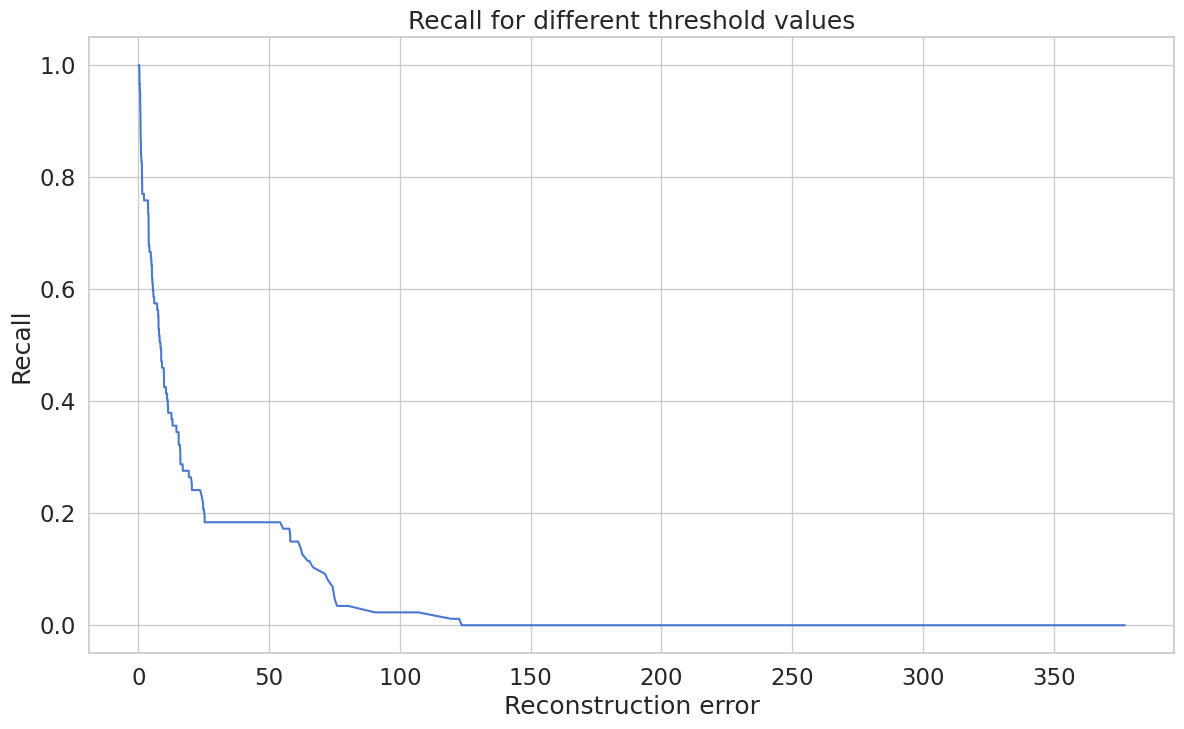

In [153]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

#Prediction
Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [154]:
threshold = 2.5

And see how well we're dividing the two types of transactions:

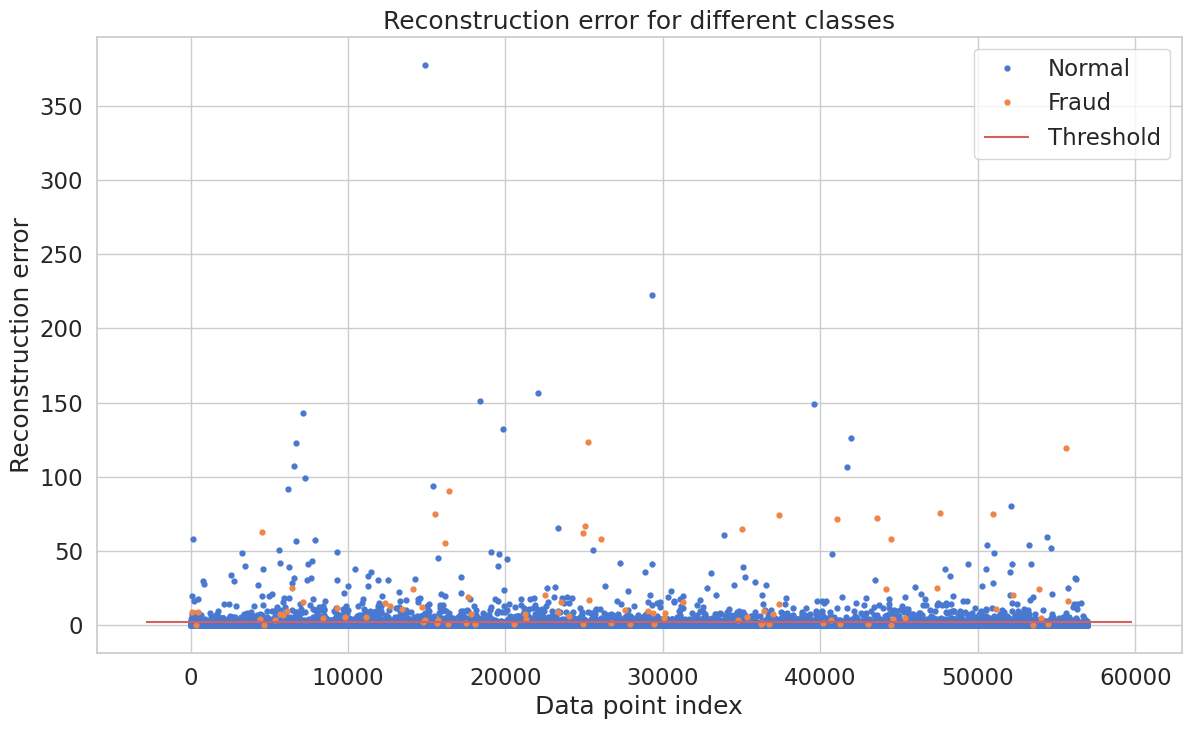

In [155]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

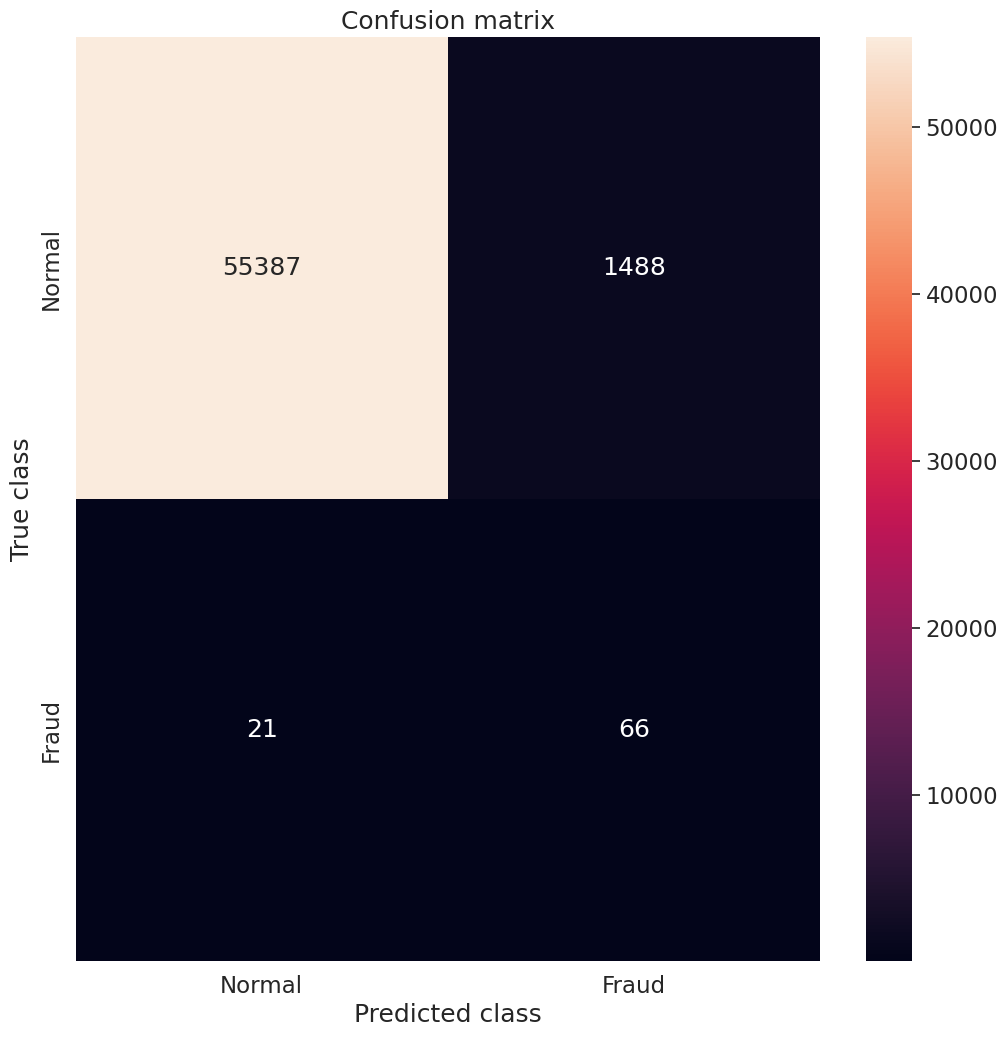

In [156]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.



In [157]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(error_df.true_class, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(error_df.true_class, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(error_df.true_class, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(error_df.true_class, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.973509
Precision: 0.042471
Recall: 0.758621
F1 score: 0.080439


In [159]:
print(classification_report(error_df.true_class,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56875
           1       0.04      0.76      0.08        87

    accuracy                           0.97     56962
   macro avg       0.52      0.87      0.53     56962
weighted avg       1.00      0.97      0.99     56962



#Conclusion
We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?

#References

*   [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
*   [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
*   [Stacked Autoencoders in TensorFlow](https://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)
